# What are autoencoders?

![autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 
1. data-specific
2. lossy
3. learned automatically from examples rather than engineered by a human

Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

## 1.Autoencoders are data-specific

which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

## 2.Autoencoders are lossy

which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

## 3.Autoencoders are learned automatically from data examples

which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

<br><br>
To build an autoencoder, you need three things: **an encoding function**, **a decoding function**, and **a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)**. 

The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

## Are they good at data compression?

Usually, not really. In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: you can only use them on data that is similar to what they were trained on, and making them more general thus requires lots of training data. But future advances might change this, who knows.

## What are autoencoders good for?
They are rarely used in practical applications. In 2012 they briefly found an application in greedy layer-wise pretraining for deep convolutional neural networks [1], but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. In 2014, batch normalization [2] started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning [3].

Today two interesting practical applications of autoencoders are **data denoising** (which we feature later in this post), and **dimensionality reduction for data visualization**. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

# A simple autoencoder based on a fully-connected layer


In [23]:
from keras.layers import Input, Dense
from keras.models import Model

In [24]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats(784/32=24.5)

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model:

In [25]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [26]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [27]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_12 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [28]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [29]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [30]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.3722 - val_loss: 0.2726
Epoch 2/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2652 - val_loss: 0.2544
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2449 - val_loss: 0.2329
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2256 - val_loss: 0.2157
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2106 - val_loss: 0.2028
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1990 - val_loss: 0.1926
Epoch 7/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.1899 - val_loss: 0.1844
Epoch 8/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.1823 - val_loss: 0.1775
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.1759 - val_loss: 0.1715
Epoch

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [31]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [32]:
import matplotlib.pyplot as plt

def draw_images(decoded_imgs):
    
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

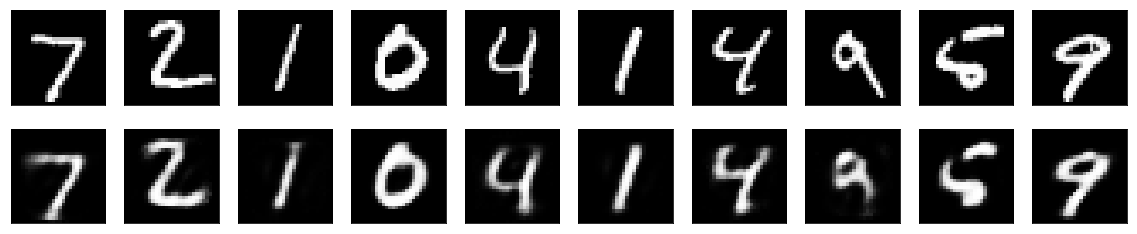

In [33]:
draw_images(decoded_imgs)

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

# Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [35]:
input_img_deep = Input(shape=(784,))
encoded_deep = Dense(128, activation='relu')(input_img_deep)
encoded_deep = Dense(64, activation='relu')(encoded_deep)
encoded_deep = Dense(32, activation='relu')(encoded_deep)

decoded_deep = Dense(64, activation='relu')(encoded_deep)
decoded_deep = Dense(128, activation='relu')(decoded_deep)
decoded_deep = Dense(784, activation='sigmoid')(decoded_deep)

autoencoder_deep = Model(input_img_deep, decoded_deep)
autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder_deep.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.3646 - val_loss: 0.2641
Epoch 2/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2590 - val_loss: 0.2513
Epoch 3/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2388 - val_loss: 0.2282
Epoch 4/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2243 - val_loss: 0.2174
Epoch 5/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2134 - val_loss: 0.2083
Epoch 6/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2059 - val_loss: 0.2016
Epoch 7/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.1964 - val_loss: 0.1888
Epoch 8/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1859 - val_loss: 0.1813
Epoch 9/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1800 - val_loss: 0.1

60000/60000 [==============================] - 2s 34us/step - loss: 0.1059 - val_loss: 0.1048
Epoch 78/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.1057 - val_loss: 0.1042
Epoch 79/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1054 - val_loss: 0.1052
Epoch 80/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1054 - val_loss: 0.1040
Epoch 81/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1052 - val_loss: 0.1047
Epoch 82/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1049 - val_loss: 0.1039
Epoch 83/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.1048 - val_loss: 0.1031
Epoch 84/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1046 - val_loss: 0.1032
Epoch 85/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1044 - val_loss: 0.1030
Epoch 86/100
60000/60000 [========================

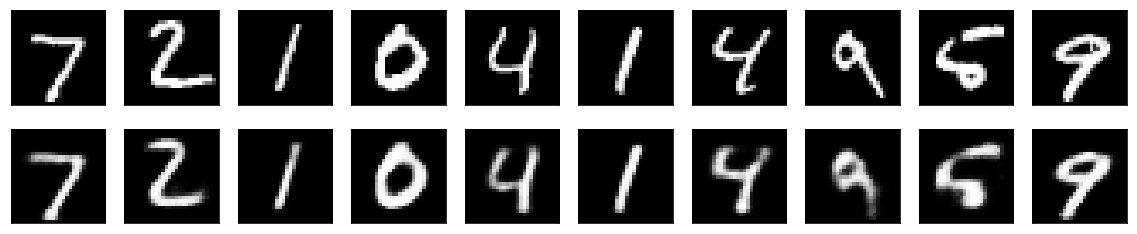

In [36]:
decoded_imgs_deep = autoencoder_deep.predict(x_test)
draw_images(decoded_imgs_deep)

# Convolutional autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [42]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img_cov  = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_cov)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded_cov = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_cov)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded_cov = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cov = Model(input_img_cov, decoded_cov)
autoencoder_cov.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_cov.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
__________

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [43]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

In [44]:
# from keras.callbacks import TensorBoard

history = autoencoder_cov.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),)
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 199us/step - loss: 0.2245 - val_loss: 0.1828
Epoch 2/50
60000/60000 [==============================] - 10s 174us/step - loss: 0.1625 - val_loss: 0.1524
Epoch 3/50
60000/60000 [==============================] - 9s 157us/step - loss: 0.1481 - val_loss: 0.1418
Epoch 4/50
60000/60000 [==============================] - 9s 158us/step - loss: 0.1391 - val_loss: 0.1361
Epoch 5/50
60000/60000 [==============================] - 10s 160us/step - loss: 0.1332 - val_loss: 0.1350
Epoch 6/50
60000/60000 [==============================] - 9s 158us/step - loss: 0.1290 - val_loss: 0.1265
Epoch 7/50
60000/60000 [==============================] - 10s 163us/step - loss: 0.1262 - val_loss: 0.1255
Epoch 8/50
60000/60000 [==============================] - 9s 152us/step - loss: 0.1237 - val_loss: 0.1194
Epoch 9/50
60000/60000 [==============================] - 10s 168us/step - loss: 0.1212 - val_loss

In [45]:
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

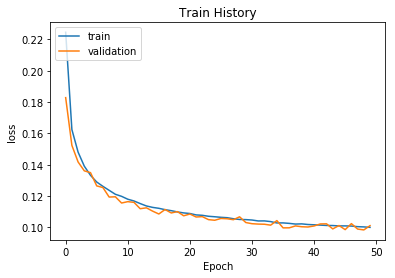

In [47]:
show_train_history(history, 'loss', 'val_loss')

The model converges to a loss of 0.098, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

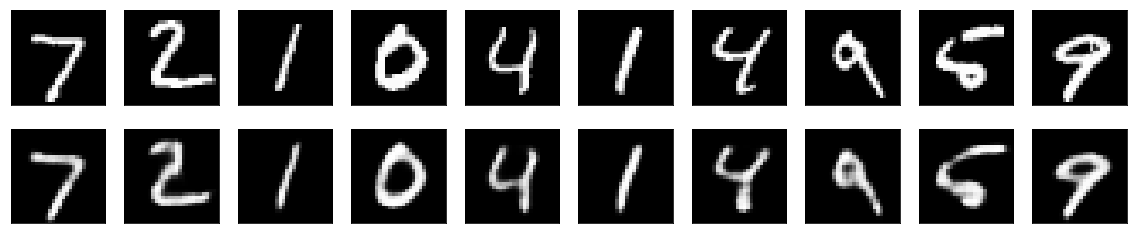

In [48]:
decoded_imgs_conv = autoencoder_cov.predict(x_test)
draw_images(decoded_imgs_conv)

# Application to image denoising
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [49]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

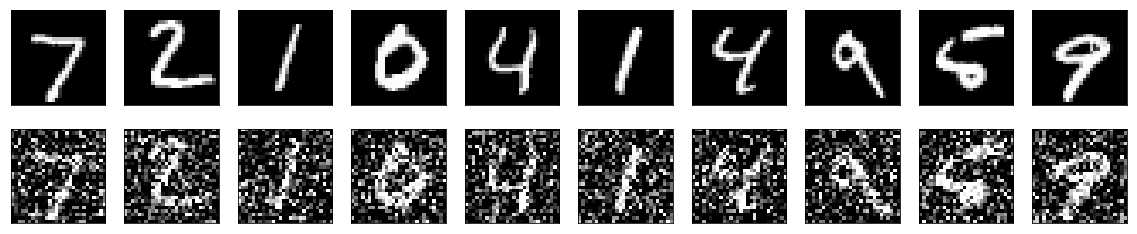

In [52]:
draw_images(x_test_noisy)

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [53]:
input_img_conv2 = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_conv2)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded_conv2 = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_conv2)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_conv2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_conv2 = Model(input_img_conv2, decoded_conv2)
autoencoder_conv2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_conv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [54]:
history = autoencoder_conv2.fit(x_train_noisy, x_train,
                     epochs=100,
                     batch_size=128,
                     shuffle=True,
                     validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 15s 254us/step - loss: 0.1963 - val_loss: 0.1338
Epoch 2/100
60000/60000 [==============================] - 14s 226us/step - loss: 0.1253 - val_loss: 0.1192
Epoch 3/100
60000/60000 [==============================] - 14s 225us/step - loss: 0.1156 - val_loss: 0.1103
Epoch 4/100
60000/60000 [==============================] - 14s 232us/step - loss: 0.1110 - val_loss: 0.1067
Epoch 5/100
60000/60000 [==============================] - 14s 226us/step - loss: 0.1083 - val_loss: 0.1050
Epoch 6/100
60000/60000 [==============================] - 14s 229us/step - loss: 0.1062 - val_loss: 0.1034
Epoch 7/100
60000/60000 [==============================] - 13s 224us/step - loss: 0.1047 - val_loss: 0.1029
Epoch 8/100
60000/60000 [==============================] - 14s 230us/step - loss: 0.1037 - val_loss: 0.1034
Epoch 9/100
60000/60000 [==============================] - 15s 244us/step - loss: 0.10

Epoch 76/100
60000/60000 [==============================] - 13s 215us/step - loss: 0.0948 - val_loss: 0.0942
Epoch 77/100
60000/60000 [==============================] - 13s 217us/step - loss: 0.0948 - val_loss: 0.0944
Epoch 78/100
60000/60000 [==============================] - 13s 218us/step - loss: 0.0947 - val_loss: 0.0944
Epoch 79/100
60000/60000 [==============================] - 13s 216us/step - loss: 0.0946 - val_loss: 0.0941
Epoch 80/100
60000/60000 [==============================] - 13s 218us/step - loss: 0.0946 - val_loss: 0.0941
Epoch 81/100
60000/60000 [==============================] - 13s 219us/step - loss: 0.0946 - val_loss: 0.0947
Epoch 82/100
60000/60000 [==============================] - 13s 214us/step - loss: 0.0946 - val_loss: 0.0941
Epoch 83/100
60000/60000 [==============================] - 13s 215us/step - loss: 0.0946 - val_loss: 0.0941
Epoch 84/100
60000/60000 [==============================] - 13s 214us/step - loss: 0.0946 - val_loss: 0.0945
Epoch 85/100
60000/

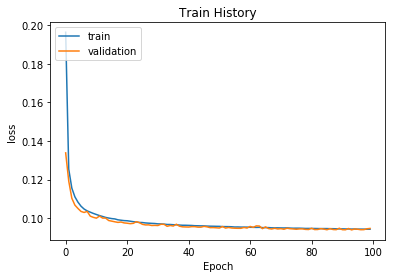

In [56]:
show_train_history(history, 'loss', 'val_loss')

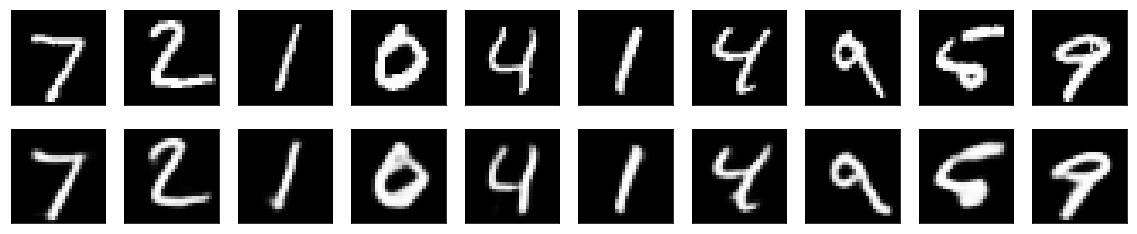

In [55]:
decoded_imgs_conv2 = autoencoder_conv2.predict(x_test_noisy)
draw_images(decoded_imgs_conv2)

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models. [Kaggle has an interesting dataset to get you started.](https://www.kaggle.com/c/denoising-dirty-documents)

<br><br><br><br>
Reference:
[Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)